## Intro

This is a silly project that started with me and my brothers watching overwatch league matches and complaining about how terrible the casters are at filling time. I was looking for a new data science personal project and figured why not try and solve our problem with machine learning. In this notebook, I've written a convolutiuon neurel network to identify gameplay and skip all other parts of the match. It actually works pretty well. [here](https://www.ndled.us/stats/2021/08/06/CV-OWL.html) is a link to me rambling about my process for the first version I put up on github

Things I read while doing this

1) http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/

2) https://www.udemy.com/course/machinelearning/learn/lecture/6761136

3) https://www.toptal.com/machine-learning/machine-learning-video-analysis

4) https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/

5) https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


In [1]:
import cv2
import math
import pandas as pd
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
import tensorflow as tf
from moviepy.editor import *
from keras.preprocessing.image import ImageDataGenerator
import subprocess
import matplotlib.pyplot as plt
import youtube_dl

In [2]:
def download(url):
    ydl_opts = {}
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download= True)
        filename = ydl.prepare_filename(info)
    return filename

In [10]:
def videoCut(videoFile, imgname):
    count = 0
    cap = cv2.VideoCapture(videoFile)
    frameRate = cap.get(5)
    while(cap.isOpened()):
        frameId = cap.get(1)
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            filename ="" + imgname + str(count).zfill(5) + ".jpg";count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    print ("Done!")

## Cutting Up Train Videos Into Frames

In [11]:
# videoCut('@Chengdu Hunters vs @Dallas Fuel _ Summer Showdown Tournament _ Day 1-5kVvsQYk2I0.mp4',
#          'train/1train_')
# videoCut('Losers Semi-Final _ @ATL Reign   vs   @Dallas Fuel _ Summer Showdown Tournament _ Day 2-RKKXYefOz5w.mp4',
#          'train/2train_')
# videoCut('Winners Finals _ @Chengdu Hunters vs  @Shanghai Dragons  _ Summer Showdown Tournament _ Day 2-hyCOml7JcrA.mp4',
#          'train/3train_')
# videoCut('Losers Finals _ @Chengdu Hunters vs @Dallas Fuel  _ Summer Showdown Tournament _ Day 2-dFcIIRQLbpo.mp4',
#          'train/4train_')

Done!


From here, I manually sorted as gameplay vs not gameplay

## Loading In Video to Process

In [7]:
url = "https://youtu.be/0aAqO0F9I88"
filename = download(url)

[youtube] 0aAqO0F9I88: Downloading webpage
[download] Destination: @Dallas Fuel vs @Paris Eternal _ Countdown Cup Qualifiers _ Week 1 Day 1 — West-0aAqO0F9I88.mp4
[download] 100% of 2.52GiB in 15:31                     


In [11]:
videoCut(filename,'pred/images/5train_')

Done!


## Data Preprocessing

In [12]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split=.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = image_generator.flow_from_directory(batch_size=32,
                                                 directory='train',
                                                 shuffle=True,
                                                 target_size=(64, 64), 
                                                 subset="training",
                                                 class_mode='binary')
test_set = image_generator.flow_from_directory(batch_size=32,
                                                 directory='train',
                                                 shuffle=True,
                                                 target_size=(64, 64), 
                                                 subset="validation",
                                                 class_mode='binary')

Found 25250 images belonging to 2 classes.
Found 6311 images belonging to 2 classes.


## Building the CNN

In [13]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the CNN

In [16]:
cnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = [tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives()])

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # model check pointing based on validation loss

In [20]:
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 20, batch_size = 32, callbacks=callbacks_list)

Epoch 1/20
790/790 [==============================] - 297s 375ms/step - loss: 0.0219 - binary_accuracy: 0.9941 - false_negatives_2: 74.0000 - false_positives: 74.0000 - val_loss: 0.0440 - val_binary_accuracy: 0.9959 - val_false_negatives_2: 3.0000 - val_false_positives: 23.0000
Epoch 2/20
790/790 [==============================] - 271s 343ms/step - loss: 0.0193 - binary_accuracy: 0.9940 - false_negatives_2: 78.0000 - false_positives: 74.0000 - val_loss: 0.0538 - val_binary_accuracy: 0.9903 - val_false_negatives_2: 1.0000 - val_false_positives: 60.0000
Epoch 3/20
790/790 [==============================] - 271s 343ms/step - loss: 0.0188 - binary_accuracy: 0.9940 - false_negatives_2: 79.0000 - false_positives: 73.0000 - val_loss: 0.0392 - val_binary_accuracy: 0.9941 - val_false_negatives_2: 5.0000 - val_false_positives: 32.0000
Epoch 4/20
790/790 [==============================] - 271s 343ms/step - loss: 0.0156 - binary_accuracy: 0.9951 - false_negatives_2: 56.0000 - false_positives: 68.0

In [23]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

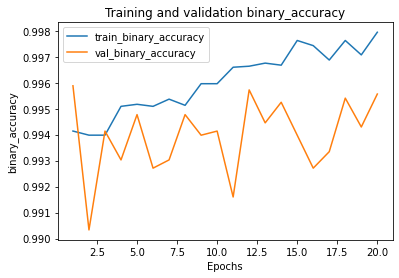

In [27]:
plot_metric(history, 'binary_accuracy')

### Saving/Loading the model

In [30]:
# cnn.save_weights("model.h5")

In [170]:
# cnn.load_weights("model.h5")

## Preprocessing Test Data

going to try and use flow from directory

In [28]:
image_generator2 = ImageDataGenerator(rescale = 1./255)

test_generator = image_generator2.flow_from_directory(batch_size=1,
                                                 directory='pred/',
                                                 target_size=(64, 64), 
                                                 class_mode=None,
                                                 shuffle = False)

Found 9397 images belonging to 1 classes.


## Predictions

In [29]:
test_generator.reset()
pred_probs=cnn.predict_generator(test_generator, steps=len(test_generator), verbose=1)

9397/9397 [==============================] - 127s 13ms/step


In [31]:
pred_probs[:10]

array([[3.9054072e-11],
       [5.7355340e-12],
       [3.9984481e-11],
       [5.5852523e-10],
       [4.1369162e-11],
       [1.2960222e-16],
       [2.6104408e-10],
       [5.0535457e-12],
       [1.7648562e-08],
       [1.7847412e-07]], dtype=float32)

In [43]:
pred_bin=(pred_probs>0.5).astype("int32")

In [44]:
sum(pred_bin)

array([5324])

So, I want some sort of averaging here. Rolling average 

In [34]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## Turning Predictions Into Something Workable

In [45]:
test_pred = (moving_average(pred_bin.ravel(),60)>.5).astype("int32")

In [46]:
test_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
count = 0
times = []
for i in range(0,len(test_pred)):
    if test_pred[i] == 1:
        times.append(i)

In [48]:
times[:10]

[242, 243, 244, 245, 246, 247, 248, 249, 250, 251]

In [49]:
count = 0
start_stop = []
for i in range(0,len(times)-1):
    if times[i] == times[i+1]-1:
        count = count + 1
    else:
        start_stop.append((times[i]-count,times[i]))
        count = 0 
start_stop

[(242, 1307),
 (1843, 2322),
 (2338, 2733),
 (2817, 2819),
 (2821, 2822),
 (2824, 3085),
 (3235, 3498),
 (3533, 3664),
 (4180, 5168),
 (5760, 5812),
 (5850, 6721),
 (7139, 7273),
 (7460, 8355),
 (8479, 8500),
 (9191, 9204)]

So the start and stop times are much more readable, but game play within a couple of minutes shouldn't be in different groups

In [52]:
reduced = [start_stop[0]]
for t in start_stop:
    if t[0] - reduced[-1][1] < 120:
        reduced[-1] = (reduced[-1][0],t[1])
    else:
        reduced.append(t)
reduced

[(242, 1307),
 (1843, 3085),
 (3235, 3664),
 (4180, 5168),
 (5760, 6721),
 (7139, 7273),
 (7460, 8355),
 (8479, 8500),
 (9191, 9204)]

Looking up above we are doing much better, but we might have a clip with tiny length, so lets make a section of code that clears anything less than 60 seconds (highlight video length)

In [53]:
final_time = []
for item in reduced:
    if item[1]-item[0] > 120:
        final_time.append(item)
final_time

[(242, 1307),
 (1843, 3085),
 (3235, 3664),
 (4180, 5168),
 (5760, 6721),
 (7139, 7273),
 (7460, 8355)]

## Writting Out Movie

In [141]:
def Cut(video,select_text):
    command = "ffmpeg -i \"{video}\" -vf \"select={select_text}, setpts=N/FRAME_RATE/TB\" -af \"aselect={select_text}, asetpts=N/SR/TB\" out.mp4".format(video=video, select_text=select_text)
    subprocess.call(command,shell=True)
    print(command)


In [ ]:
def ffmpeg_time_format(final_times):
    select_text = "'"
    for i in range(0,len(final_time)):
        select_text = select_text+"between(t,"+str(final_time[i][0]-30)+","+str(final_time[i][1]+30)+")"
        if i < len(final_time)-1:
            select_text = select_text + "+"
    select_text = select_text + "'"
    return select_text

In [143]:
Cut(filename,select_text)

ffmpeg -i "@Dallas Fuel vs @Paris Eternal _ Countdown Cup Qualifiers _ Week 1 Day 1 — West-0aAqO0F9I88.mp4" -vf "select='between(t,212,1337)+between(t,1813,3115)+between(t,3205,3694)+between(t,4150,5198)+between(t,5730,6751)+between(t,7109,7303)+between(t,7430,8385)', setpts=N/FRAME_RATE/TB" -af "aselect='between(t,212,1337)+between(t,1813,3115)+between(t,3205,3694)+between(t,4150,5198)+between(t,5730,6751)+between(t,7109,7303)+between(t,7430,8385)', asetpts=N/SR/TB" out.mp4


## Depricated - Moviepy method

In [151]:
# clip = VideoFileClip(videoFile)
# final = concatenate([clip.subclip(max(final_time[i][0]-30,0), min(final_time[i][1]+30,clip.duration)) for i in range(0,len(final_time))])
# final.to_videofile('test3.mp4')

Moviepy - Building video test3.mp4.
MoviePy - Writing audio in test3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video test3.mp4



Moviepy - Done !
Moviepy - video ready test3.mp4


## Next Steps

~~1) Setup image generator for the predictions. Right now this takes an ungodly amount of ram~~

~~2) Make a callout for youtube.dl to run everything from this one notebook~~

~~3) Add more trainning Data~~

~~4) Increase the number of Epochs for the CNN - once I stop adding to the training data~~

5) Add in layer graphics

~~6) Add higher weights for not gameplay time~~

7) Build a progress bar for cutting up the images

~~9) Switch over to ffmpeg, maybe, Working on this now and I'm not getting a time advantage.~~

10) Work on optimizing speed fpr ffmpeg, accept some lower quality